In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from aimanager.utils.utils import make_dir

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../../data'
rl_data_folder = '../../data/dev/data'
merge_file = 'pilot_random1'
plot_folder = 'plots/skema_talk'

make_dir(plot_folder)

In [6]:
df = pd.read_csv(os.path.join(folder, f'{merge_file}_player_round.csv'))
df2 = pd.read_parquet(os.path.join(rl_data_folder, 'artificial_human_simulation.parquet'))
df3 = pd.read_parquet(os.path.join(rl_data_folder, 'artificial_human_rl_simulation.parquet'))

In [7]:
df.groupby('experiment_name')['player_no_input'].value_counts(normalize=True)

experiment_name  player_no_input
random_1         0                  0.986288
                 1                  0.013712
trail_rounds_2   0                  0.972304
                 1                  0.027696
Name: player_no_input, dtype: float64

In [8]:
df['common_good'] = df['contribution'] * 1.6 - df['punishment']
df['experiment_name'] = df['experiment_name']# + ' eps ' + df['episode'].astype(str)
df['round_number'] = df['round_number'] + (df['episode']-1) * 8
df2['experiment_name'] = 'simmulation'
df2['global_group_id'] = df2['episode'].astype(str)
df2['episode'] = 1
df3['experiment_name'] = 'simmulation_rl'
df3['global_group_id'] = df3['episode'].astype(str) + '_rl'
df3['episode'] = 1
value_map = {
    'contributions': 'contribution',
    'punishments': 'punishment',
    'contribution': 'contribution',
    'punishment': 'punishment',
    'common_good': 'common good',
}

manager_map = {
    'trail_rounds_2': 'human manager',
    'random_1': 'stochastic rule',
    'simmulation': 'optimal rule',
    'simmulation_rl': 'RL manager'
}

group_map = {
    'trail_rounds_2': 'human',
    'random_1': 'human',
    'simmulation': 'artificial human',
    'simmulation': 'artificial human'
}


dfm = df.melt(
    id_vars=['global_group_id', 'round_number', 'participant_code', 'episode', 'experiment_name'], 
    value_vars=['punishment', 'contribution', 'common_good'], value_name='value', var_name='name')
dfm = pd.concat([dfm, df2, df3]).reset_index(drop=True)
dfm['name'] = dfm['name'].map(value_map)
dfm['episode'] = dfm['episode'].astype(str)
dfm['manager'] = dfm['experiment_name'].map(manager_map)
dfm['group'] = dfm['experiment_name'].map(group_map)

dfm = dfm.rename(columns={'round_number': 'round number', 'name': 'metric'})

df_timeevo = dfm

df['manager'] = df['experiment_name'].map(manager_map)
df['group'] = df['experiment_name'].map(group_map)

### We collected a large data set of humans being managed by a human manager

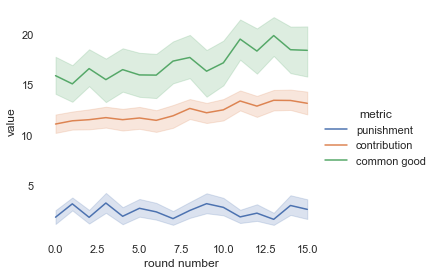

In [9]:
w = (
    df_timeevo['manager'] == 'human manager'
)

g = sns.relplot(
    data=df_timeevo[w],
    x="round number", y="value",
    # col='episode',
    hue='metric',
    kind="line",
    height=4, aspect=1.2
)
plt.savefig(os.path.join(plot_folder, 'temporal_human_manager.jpg'), dpi=300, transparent=False)


* Contributions are only mildly increasing over the 16 rounds we recorded
* Are human manager failing?

In [10]:
from aimanager.model.cross_validation import split_xy
import numpy as np

# w = (
#     df['manager'] == 'human manager'
# )

df_x, sr_y = split_xy(df, filter_nan=True)

df_xy = df_x
df_xy['contribution'] = sr_y

df_xy[['contribution', 'punishment', 'next_contribution']] = df_xy[['prev_contribution', 'prev_punishment', 'contribution']].astype(int)

df_xy = df_xy.reset_index()
df_count_pt = df_xy.pivot_table(index=['prev_manager', 'contribution'], columns='punishment', values='next_contribution', aggfunc=len)

f, (ax1) = plt.subplots(1, 1, figsize=(8,6))
ax1.set_title('$log_{10}$ frequency')
sns.heatmap(df_count_pt.loc['human manager'].T.iloc[::-1], ax=ax1)
plt.savefig(os.path.join(plot_folder, 'pun_cont_count_human_manager.jpg'), dpi=300, transparent=False)

ModuleNotFoundError: No module named 'aimanager.model'

* Human manager generally punish low 
* if they punish, it is often not targeted at defectors

## We collected a data set of humans playing against a punishment rule

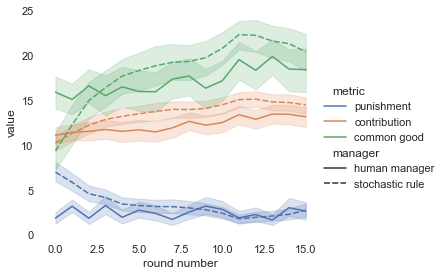

In [ ]:
w = (
    df_timeevo['group'] == 'human'
)

g = sns.relplot(
    data=df_timeevo[w],
    x="round number", 
    y="value",
    # col='episode',
    hue='metric',
    kind="line",
    style='manager',
    height=4, aspect=1.2
)
plt.savefig(os.path.join(plot_folder, 'temporal_human_manager.jpg'), dpi=300, transparent=False)

* participants started with much less contributions initially (i.e. due to reframing)
* the punishment rule leads to higher contributions eventually

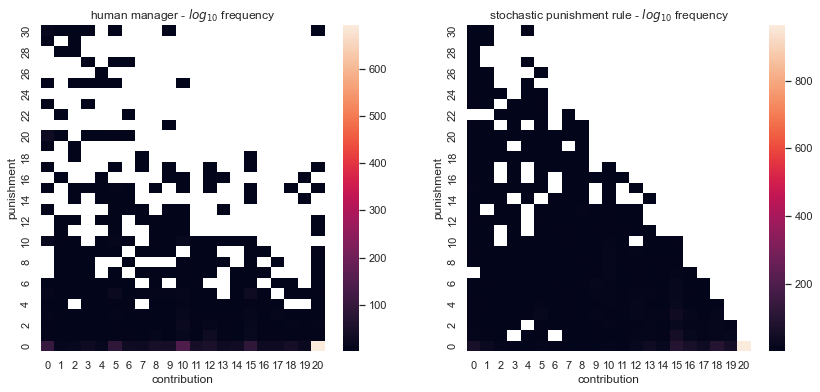

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title('human manager - $log_{10}$ frequency')
sns.heatmap(df_count_pt.loc['human manager'].T.iloc[::-1], ax=ax1)

ax2.set_title('stochastic punishment rule - $log_{10}$ frequency')
sns.heatmap(df_count_pt.loc['stochastic rule'].T.iloc[::-1], ax=ax2)

plt.savefig(os.path.join(plot_folder, 'pun_cont_count_pilot.jpg'), dpi=300, transparent=False)

* the punishment rule samples well accross all reasonable punishments
* question remains: what is the most efficient punishment?

## Artificial group member

### Motivation

* it is unfeasable to test each potential punishment policy in a experiment
* the "optimal" punishment policy can be arbitarily complex (group dynamic / personalisation)

### Concept

* we train "artificial group member" to mimick human behavior in this specific game
* we use these "artificial group member" to train a policy using reinforcment learning

### Method ("artificial group member")

* Input: previous contributions, previous punishments
* Output: distribution of expected next contribution 
* currently
    * Neural network (2 layer perceptron)
* upcoming
    * Graph Neural Networks to encode social influence (group dynamic)
    * Recurrent Units to encode full history (personalisation)

## 1. Manager - optimal myopic rule

### Method

* myopic reward: {expected contribution in next round} * 1.6 - selected punishment
* optimize the punishment to maximize the myopic reward

### Results

#### Punishment rule

* punishment rule suggest relative large punishments for small defects
    * defect of 1 -> punishment of 3
    * defect of 2 -> punishment of 6
    * larger defects -> punishment < 5 
    * some noisy outlier for very low contributions
* punishment becomes to costly if expected improvement in contributions is small (social influence is missing!)

#### Simulation

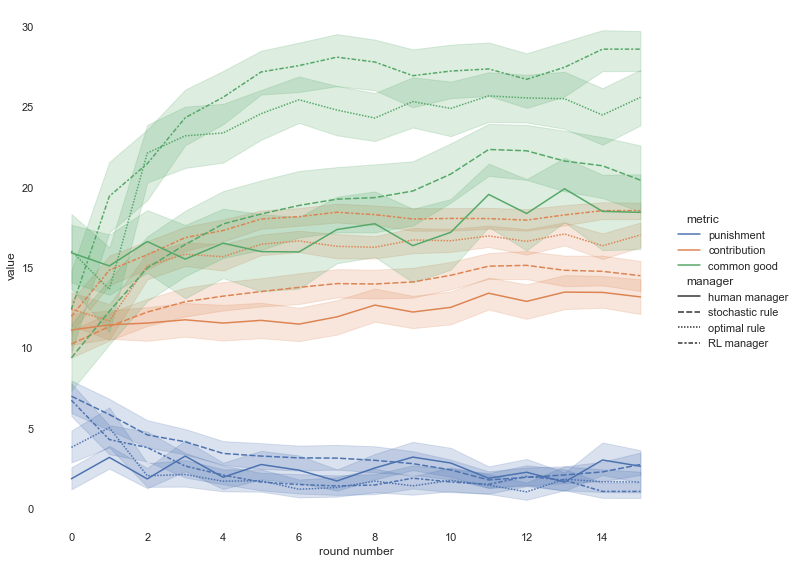

In [ ]:
g = sns.relplot(
    data=dfm,
    x="round number", y="value",
    # col='episode',
    hue='metric',
    kind="line",
    style='manager',
    height=8, aspect=1.2,
)
plt.savefig(os.path.join(plot_folder, 'artifical_human_temporal.jpg'), dpi=300, transparent=False)

* Myopic manages to establish higher cooperation with artificial humans compared to the human manager and the stochastic rule with actual humans

# 2. Manager - optimal rule

## Method

* deep reinforcment learning (http://dx.doi.org/10.1038/nature14236)
* multilayer preceptron
* input: contribution, round number
* output: punishment

## Results

/// i am on it

## Outlook

* currently both the "artificial humans" and the "manager" can be described as a rule

### Advantage of the method

* Neural networks allow to describe arbitary functional relationship (https://www.cs.cmu.edu/~bhiksha/courses/deeplearning/Fall.2016/notes/Sonia_Hornik.pdf)
* without changing the setup, the method generalizes to more complex policies that include temporal and social compontents

### Next steps

#### Advancing the "artificial humans" and the "manager"
* Recurrent Neural Networks to describe arbitary temporal relationship
* Graph Neural Network to to describe interaction on between group members {fully connected graph in our case}

#### Testing the "manager" with human participants

### Challenges

* avoid overfitting on the large but limited dataset
* generalisation of the "artificial humans" to novel behavior of the manager

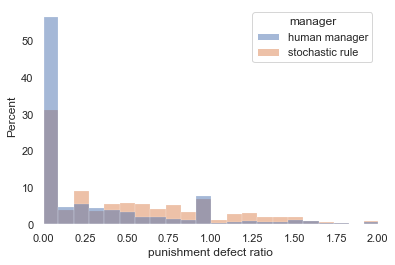

In [ ]:
df['punishment defect ratio'] = df['punishment'] / (20-df['contribution'])

w = (
    df['group'] == 'human'
)

sns.histplot(data=df, x='punishment defect ratio', hue='manager', stat='percent', common_norm=False)
plt.xlim(0,2)
plt.savefig(os.path.join(plot_folder, 'punishment_defect_ratio.jpg'), dpi=300, transparent=False)